In [1]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/2025/parsonage.txt', sep = ' ', engine='python')

In [3]:
# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values

# 1. SN data

## 1-1. Flat LCDM

In [62]:
import sys
sys.path.append('/home/john1256/KASI/KASI_Ms/2025')
from utils_flat import MCMC, ln_prior, Loglikelihood, B, A, Other_stuff_flat, E_inverse_flat, Markov, ln_f

In [63]:
Prior1 = np.array([[0.],[1.]])

In [70]:
normal_vec = np.array([3.587001117896503e-06])*0.01
std = np.array([7.207595017419446e-06])
paraminit = np.array([5.95230321791345e-10]) + np.random.normal(0,std)
nstep = int(2e3)
MCMC_test = MCMC(Other_stuff_flat, paraminit, sndata, nstep, normal_vec, Prior1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.74it/s]


accept_ratio = 0.20444444444444446
Best_fit = Omega_m : 8.112874862345025e-11
std = 1.2177074856368425e-06


(array([1639.,   10.,    6.,    9.,    5.,    6.,    6.,    4.,    3.,
           8.,    4.,   11.,   10.,    9.,   11.,    6.,   10.,   12.,
          12.,    4.,    5.,   10.,    9.,    2.,    3.,    8.,    5.,
           4.,   16.,    5.,    6.,    6.,   13.,    6.,    7.,    3.,
           3.,    3.,   15.,    9.,    2.,   15.,    7.,    7.,    8.,
          10.,    8.,    7.,    4.,    9.]),
 array([8.11287486e-11, 1.05261251e-07, 2.10441373e-07, 3.15621495e-07,
        4.20801618e-07, 5.25981740e-07, 6.31161862e-07, 7.36341984e-07,
        8.41522107e-07, 9.46702229e-07, 1.05188235e-06, 1.15706247e-06,
        1.26224260e-06, 1.36742272e-06, 1.47260284e-06, 1.57778296e-06,
        1.68296308e-06, 1.78814321e-06, 1.89332333e-06, 1.99850345e-06,
        2.10368357e-06, 2.20886370e-06, 2.31404382e-06, 2.41922394e-06,
        2.52440406e-06, 2.62958418e-06, 2.73476431e-06, 2.83994443e-06,
        2.94512455e-06, 3.05030467e-06, 3.15548480e-06, 3.26066492e-06,
        3.36584504e-06, 

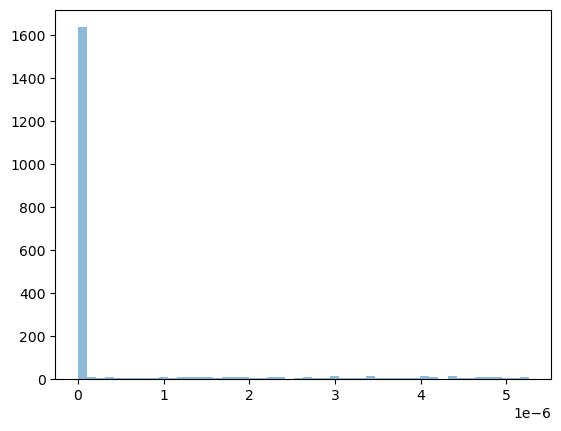

In [71]:

#MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)

Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0])
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}')
print(f'std = {std}')
plt.hist(MCMC_test[0],bins=50,alpha=0.5, label='Omega_m')

In [ ]:
# test
def Other_stuff_test(z, parm): # parm[0] = Omegam, parm[1] = Omegalamb
    Omegam = parm[0]
    grid_dist = np.array([quad_vec(E_inverse_flat, 0,n, args=(Omegam))[0] for n in z])
    return grid_dist
def Loglikelihood(func, parm,SNdata): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    mb = SNdata['mb'].values
    dmb = SNdata['dmb'].values
    z = SNdata['zcmb'].values
    m_z = A(func, mb,dmb, z, parm) + B(func,parm, z) # m_z = A + integral
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq

In [ ]:
parm = np.array([0.1])
Error = np.abs(Other_stuff_flat(z, parm) - Other_stuff_test(z, parm)).mean()
Error2 = np.abs(B(Other_stuff_flat, parm, z) - B(Other_stuff_test, parm, z)).mean()
Error3 = np.abs(A(Other_stuff_flat, mb, dmb, z, parm) - A(Other_stuff_test, mb, dmb, z, parm)).mean()
print(f'Error = {Error}, Error2 = {Error2}, Error3 = {Error3}')


Error = 7.258364581630221e-07, Error2 = 1.785897351411649e-05, Error3 = 0.02222413765048259


## 1-2. Curved LCDM

In [4]:
import sys
sys.path.append('/home/john1256/KASI/KASI_Ms/2025')
from utils_curved import MCMC, ln_prior, Loglikelihood, ln_f, Markov, A, B, Other_stuff_curved, E_inverse_curved  

In [5]:
import multiprocessing as mp

In [ ]:
def run_mcmc_test(seed):
    np.random.seed(seed)
    Prior2 = np.array([[0., 0.],[2.5, 2.5]])
    std = np.array([5.35304356e-07, 8.92840011e-07])
    normal_vec = np.array([4.51219990e-06, 8.92060889e-06])*0.12
    paraminit = np.array([0.13802552213832014,  1.413403927941591]) + np.random.normal(0,std)
    nstep = int(1e3)
    return MCMC(Other_stuff_curved, paraminit, sndata, nstep, normal_vec, Prior2)

if __name__ == '__main__':
    n_chain = 4
    with mp.Pool(processes=n_chain) as pool:
        results = pool.map(run_mcmc_test, range(n_chain))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.61it/s]


In [95]:
results[0][:, 200:].shape  # Discard the first 200 steps as burn-in

(3, 800)

In [96]:
burn_in = 200
MCMC_test = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)

accept_ratio = 0.1975
Best_fit = Omega_m : 0.13802555267933977, Omegalamb : 1.4134039702654473
std = [3.92937281e-07 6.47471980e-07]


Text(0.5, 1.0, 'MCMC result for Flat LCDM')

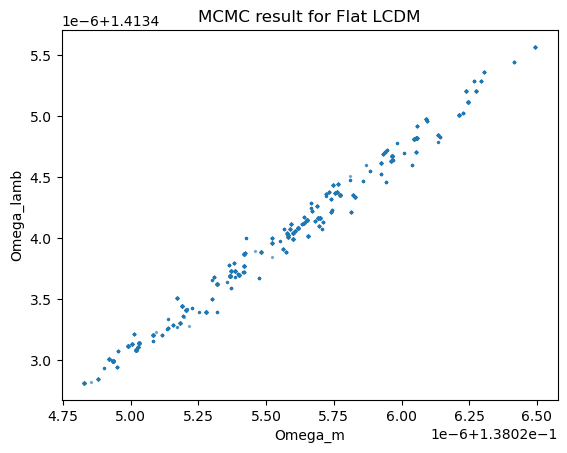

In [97]:
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}')
print(f'std = {std}')
plt.scatter(MCMC_test[0], MCMC_test[1], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Omega_lamb')
plt.title('MCMC result for Flat LCDM')

In [9]:
def run_mcmc_fin(seed):
    np.random.seed(seed)
    Prior2 = np.array([[0., 0.],[2.5, 2.5]])
    std = np.array([5.35304356e-07, 8.92840011e-07])
    normal_vec = np.array([4.51219990e-06, 8.92060889e-06])*0.12
    paraminit = np.array([0.13802552213832014,  1.413403927941591]) + np.random.normal(0,std)
    nstep = int(3*1e5)
    return MCMC(Other_stuff_curved, paraminit, sndata, nstep, normal_vec, Prior2)

if __name__ == '__main__':
    n_chain = 4
    with mp.Pool(processes=n_chain) as pool:
        results = pool.map(run_mcmc_fin, range(n_chain))
for i in range(n_chain):
    np.save(f'MCMC_curved_SN_{i}.npy', results[i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [2:02:59<00:00, 40.65it/s]


accept_ratio = 0.10298489932885906
Best_fit = Omega_m : 0.138025559151496, Omegalamb : 1.4134039799134672
std = [3.58360169e-07 5.96301276e-07]


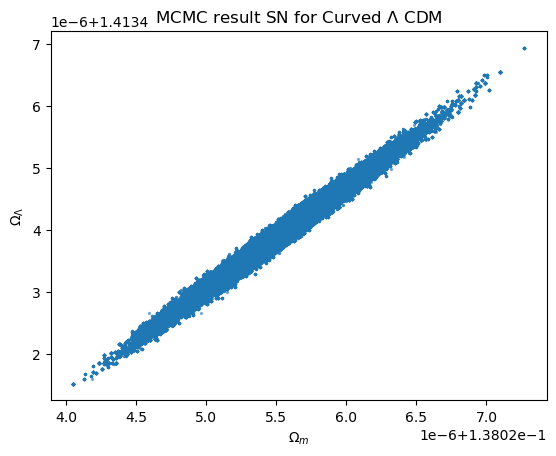

In [52]:
results = np.load(f'MCMC_curved_SN_0.npy'), np.load(f'MCMC_curved_SN_1.npy'), np.load(f'MCMC_curved_SN_2.npy'), np.load(f'MCMC_curved_SN_3.npy')
burn_in = 2000
MCMC_fin = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)
nstep = MCMC_fin.shape[1]
accept_ratio = np.unique(MCMC_fin).shape[0] / (nstep)
Best_fit = MCMC_fin[:,np.argmax(MCMC_fin[-1])]
std = np.std(MCMC_fin[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}')
print(f'std = {std}')
plt.scatter(MCMC_fin[0], MCMC_fin[1], s=2, alpha=0.5)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title(r'MCMC result SN for Curved $\Lambda$ CDM')
plt.savefig('MCMC_result_curved_LCDM.png')

# 2. SN + BAO data

In [2]:
# BAO data
BAO_z = np.array([0.01115,0.157,0.389,0.389,0.536,0.536,0.626,0.626])
BAO_val = np.array([0.08,1906.18,3905.35,43.56,4761.80,50.83,5175.36,57.19])
BAO_err = np.array([0.003,66.577,58.667,1.310,68.866,1.531,77.639,1.336])
BAO_ind = np.array([1,2,3,4,3,4,3,4]) 
# 1 : r_s/D_V, 2 : D_V(r_d,fid/r_d), 3 : D_M(r_d,fid/r_d), 4 : H(r_d/r_d,fid)
BAO_data = pd.DataFrame({
    'z': BAO_z,
    'val': BAO_val,
    'err': BAO_err,
    'ind': BAO_ind
})

## 2-1. Flat LCDM

In [ ]:
import sys
import os
sys.path.append('/home/john1256/KASI/KASI_Ms/2025')
from utils_flat_BAO import *
import multiprocessing as mp

In [20]:
def run_mcmc_test(seed):
    np.random.seed(seed)
    Prior2 = np.array([[0., 4.66594018],[1, 36.39070654]])
    std = np.array([3.56889533e-07, 1])
    normal_vec = np.array([3.56889533e-07, 1])*0.1
    paraminit = np.array([3.8349858405989014e-06,  32.376260984767136]) + np.random.normal(0,std)
    nstep = int(1e3)
    return MCMC(Other_stuff_flat, BAO_flat, paraminit, sndata,BAO_data, nstep, normal_vec, Prior2)

if __name__ == '__main__':
    n_chain = 4
    with mp.Pool(processes=n_chain) as pool:
        results = pool.map(run_mcmc_test, range(n_chain))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.21it/s]


In [21]:
burn_in = 400
MCMC_test = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)

accept_ratio = 0.013333333333333334
Best_fit = Omega_m : 3.1218097089934426e-06, Omegalamb : 36.389860089053855
std = [2.70195156e-08 2.06650756e-03]


Text(0.5, 1.0, 'MCMC result for Flat LCDM')

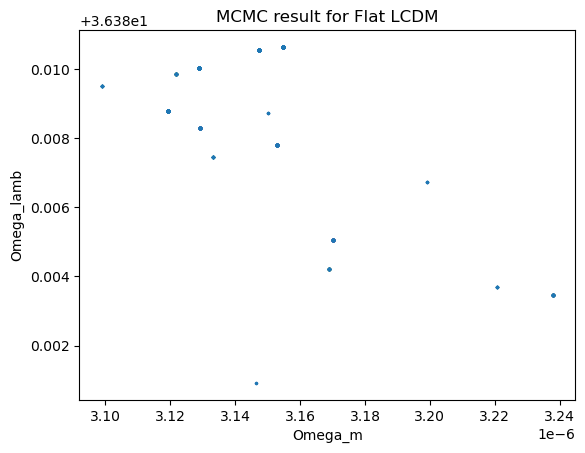

In [22]:
accept_ratio = np.unique(MCMC_test).shape[0] / (4e3-burn_in)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}')
print(f'std = {std}')
plt.scatter(MCMC_test[0], MCMC_test[1], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Omega_lamb')
plt.title('MCMC result for Flat LCDM')

## 2-2. Curved LCDM

In [3]:
import sys
sys.path.append('/Users/john1256/KASI_Ms/2025/')
from utils_curved_BAO import *
import multiprocess as mp

In [43]:
def run_mcmc_test(seed):
    np.random.seed(seed)
    Prior2 = np.array([[0.,0., 4.66594018],[2.5,2.5, 36.39070654]])
    std = np.array([5.35304356e-07, 8.92840011e-07,0.01])
    normal_vec = np.array([4.51219990e-06, 8.92060889e-06, 0.5])*0.07
    paraminit = np.array([0.1380254152198886,  1.4134037103696058,36.38747348820103]) + np.random.normal(0,std)
    nstep = int(1e3)
    return MCMC(Other_stuff_curved, BAO_curved, paraminit, sndata,BAO_data, nstep, normal_vec, Prior2)

In [44]:
n_chain = 4
with mp.Pool(processes=n_chain) as pool:
    results = pool.map(run_mcmc_test, range(n_chain))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.31it/s]
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There a

In [45]:
burn_in = 400
MCMC_test = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)

accept_ratio = 0.23708333333333334
Best_fit = Omega_m : 0.13802550418574108, Omegalamb : 1.413403904892081, H0 : 36.38213608397651
std = [3.23513372e-07 5.26541214e-07 1.65449869e-02]


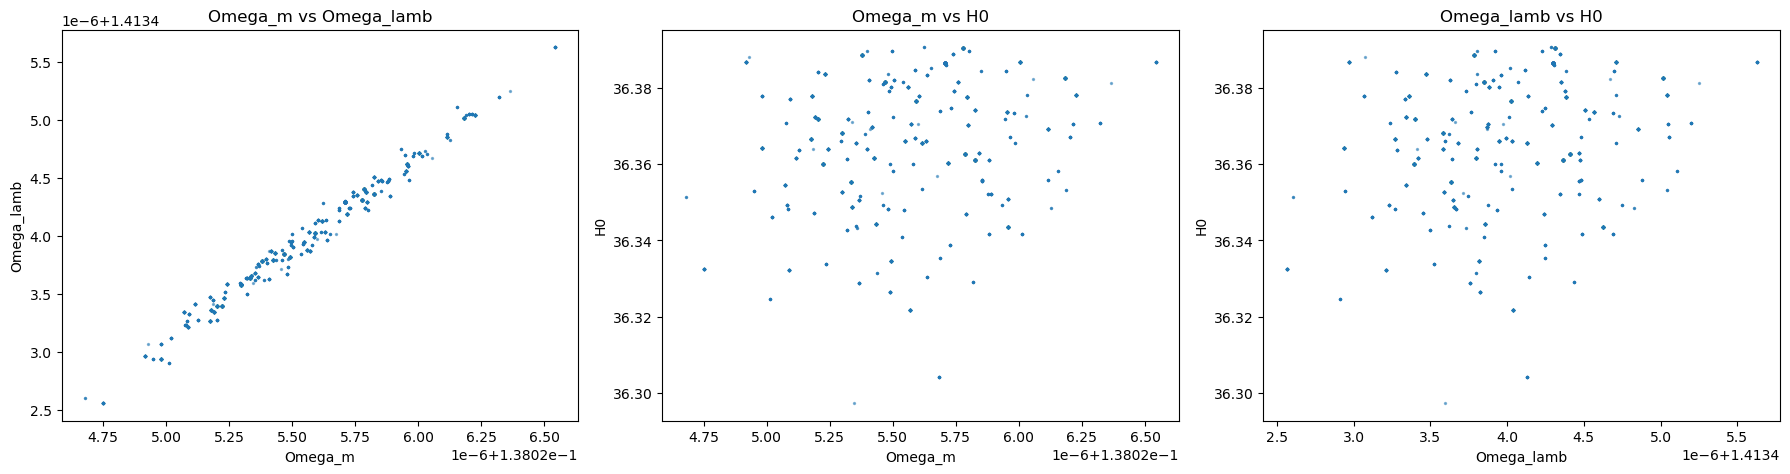

In [46]:
accept_ratio = np.unique(MCMC_test).shape[0] / (4e3-burn_in*4)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}, H0 : {Best_fit[2]}')
print(f'std = {std}')
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Omega_m vs Omega_lamb
axs[0].scatter(MCMC_test[0], MCMC_test[1], s=2, alpha=0.5)
axs[0].set_xlabel('Omega_m')
axs[0].set_ylabel('Omega_lamb')
axs[0].set_title('Omega_m vs Omega_lamb')

# 2. Omega_m vs H0
axs[1].scatter(MCMC_test[0], MCMC_test[2], s=2, alpha=0.5)
axs[1].set_xlabel('Omega_m')
axs[1].set_ylabel('H0')
axs[1].set_title('Omega_m vs H0')

# 3. Omega_lamb vs H0
axs[2].scatter(MCMC_test[1], MCMC_test[2], s=2, alpha=0.5)
axs[2].set_xlabel('Omega_lamb')
axs[2].set_ylabel('H0')
axs[2].set_title('Omega_lamb vs H0')

plt.tight_layout()
plt.show()

In [31]:
def run_mcmc_fin(seed):
    np.random.seed(seed)
    Prior2 = np.array([[0.,0., 4.66594018],[2.5,2.5, 36.39070654]])
    std = np.array([5.35304356e-07, 8.92840011e-07,0.01])
    normal_vec = np.array([4.51219990e-06, 8.92060889e-06, 0.5])*0.07
    paraminit = np.array([0.1380254152198886,  1.4134037103696058,36.38747348820103]) + np.random.normal(0,std)
    nstep = int(2*1e5)
    return MCMC(Other_stuff_curved, BAO_curved, paraminit, sndata,BAO_data, nstep, normal_vec, Prior2)

In [32]:
n_chain = 4
with mp.Pool(processes=n_chain) as pool:
    results = pool.map(run_mcmc_fin, range(n_chain))
for i in range(n_chain):
    np.save(f'MCMC_curved_SN+BAO_{i}.npy', results[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [5:55:47<00:00,  9.37it/s]
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There a

In [54]:
results = np.load(f'MCMC_curved_SN+BAO_0.npy'), np.load(f'MCMC_curved_SN+BAO_1.npy'), np.load(f'MCMC_curved_SN+BAO_2.npy'), np.load(f'MCMC_curved_SN+BAO_3.npy')
burn_in = 1000
MCMC_fin = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)

accept_ratio = 0.43908673469387755
Best_fit = Omega_m : 0.13802555176344997, Omegalamb : 1.4134039721922746, H0 : 36.38837588817553
std = [3.60712819e-07 5.99805217e-07 1.75398599e-02]


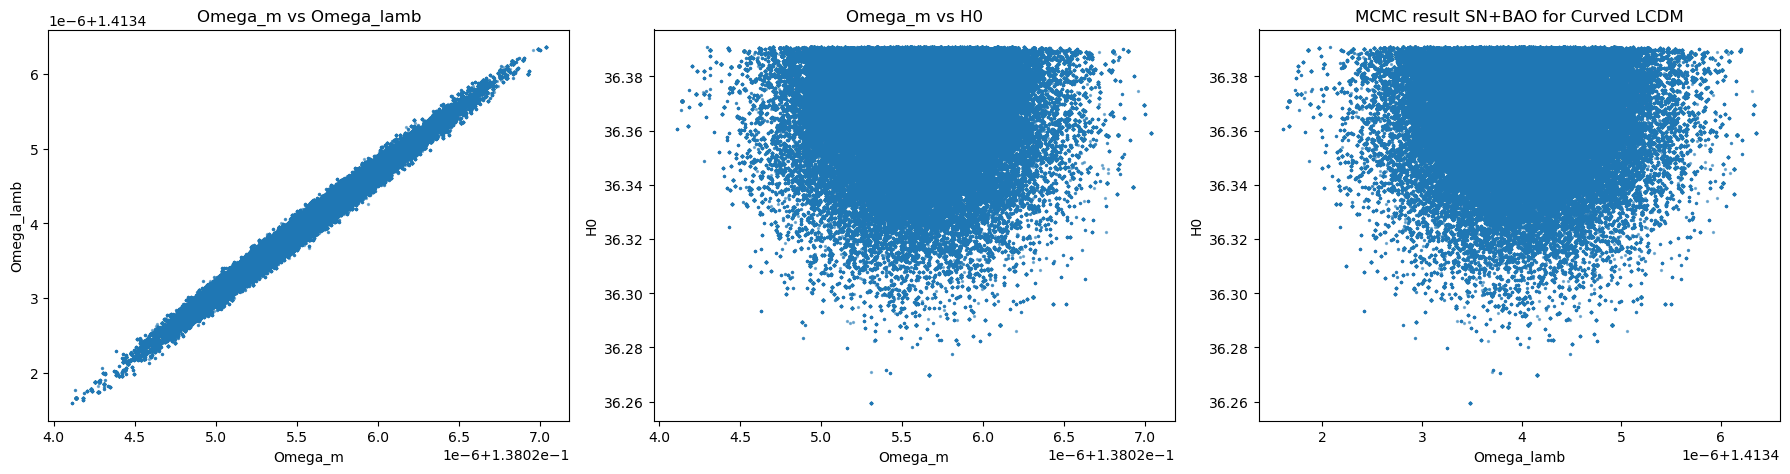

In [55]:
accept_ratio = np.unique(MCMC_fin[0:2]).shape[0] / (2*1e5-burn_in*4)
Best_fit = MCMC_fin[:,np.argmax(MCMC_fin[-1])]
std = np.std(MCMC_fin[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}, H0 : {Best_fit[2]}')
print(f'std = {std}')
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Omega_m vs Omega_lamb
axs[0].scatter(MCMC_fin[0], MCMC_fin[1], s=2, alpha=0.5)
axs[0].set_xlabel('Omega_m')
axs[0].set_ylabel('Omega_lamb')
axs[0].set_title('Omega_m vs Omega_lamb')

# 2. Omega_m vs H0
axs[1].scatter(MCMC_fin[0], MCMC_fin[2], s=2, alpha=0.5)
axs[1].set_xlabel('Omega_m')
axs[1].set_ylabel('H0')
axs[1].set_title('Omega_m vs H0')

# 3. Omega_lamb vs H0
axs[2].scatter(MCMC_fin[1], MCMC_fin[2], s=2, alpha=0.5)
axs[2].set_xlabel('Omega_lamb')
axs[2].set_ylabel('H0')
axs[2].set_title('Omega_lamb vs H0')
plt.title('MCMC result SN+BAO for Curved LCDM')
plt.tight_layout()
plt.savefig('MCMC_result_curved_LCDM_SN+BAO.png')
plt.show()